In [24]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
from datetime import datetime
from packaging import version
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import numpy as np

from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import csv
import scipy.stats as stats
from tensorboard.plugins.hparams import api as hp
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)

import seaborn as sns
from Data import Data
from datetime import datetime
import feature_finder_keiko as ff
plt.rcParams["figure.figsize"] = (20,10)

In [26]:
step = 1
train_start = np.arange(1948,1977,step)
validation_end = np.arange(1982,2011,step)
test_start = np.arange(1983,2012,step)
test_end = np.arange(1987,2016,step)

n_components_sst = np.load("sst_number.npy")

In [27]:
tau = 12
f = 12
level = 99
extremes_treshold = -1
tau = 12

In [28]:
class_list = np.load("ET_class_list.npy")
class_name = "Aw"
index = (np.array(class_list) == class_name)

In [29]:
ijz = -11
temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries_class("ET_gamma_18912015_12.npy",index,train_start[ijz],validation_end[ijz],extremes_treshold = extremes_treshold)

In [30]:
data_sst = np.load("data_sst.npy")
V = np.load("V.npy")
ts = np.load("ts.npy")
avg = np.load("avg.npy")
std = np.load("std.npy")
data_sst_test = np.load("data_sst_test.npy")
df_sst = pd.read_csv("df_sst.csv")

In [34]:
link  = np.load("../../whole_data_results/ET_orac/best_link_{}_{}/pcmci_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),class_name,f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))

In [32]:
temporal_limits_test = {"time_min":datetime(test_start[ijz], 1, 1, 0, 0),"time_max":datetime(test_end[ijz], 12, 1, 0, 0)}
#data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries_class("ET_gamma_18912015_12.npy",index,test_start[ijz],test_end[ijz],extremes_treshold = extremes_treshold)

del df_sst["Unnamed: 0"]

In [37]:
df

,drought,drought (t-12),drought (t-13),drought (t-14),drought (t-15),drought (t-16),drought (t-17),drought (t-18),drought (t-19),drought (t-20),drought (t-21),drought (t-22),drought (t-23)
0,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,32,26.0,28.0,22.0,18.0,13.0,19.0,14.0,10.0,10.0,2.0,0.0,0.0
416,29,28.0,26.0,28.0,22.0,18.0,13.0,19.0,14.0,10.0,10.0,2.0,0.0
417,30,29.0,28.0,26.0,28.0,22.0,18.0,13.0,19.0,14.0,10.0,10.0,2.0
418,24,28.0,29.0,28.0,26.0,28.0,22.0,18.0,13.0,19.0,14.0,10.0,10.0


In [35]:
link

array([[  8, -23],
       [  3, -19],
       [ 43, -14],
       [  4, -23]])

In [36]:
start_lag = tau
end_lag = tau+11

df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

ValueError: Length of values does not match length of index

In [ ]:
start_lag = tau
end_lag = tau + 11

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    #df_test[str(k)] = ff.time_series_maker_V(data_sst_test, V[:,link[k,0]-1])
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [18]:
step = 1
train_start = np.arange(1951,1952,step)
validation_end = np.arange(2000,2001,step)
test_start = np.arange(2001,2002,step)
test_end = np.arange(2005,2006,step)

#n_components_sst = np.load("sst_number.npy")
n_components_sst = [69]


tau = 12
f = 12
level = 99
extremes_treshold = -1

In [19]:
test_start = np.arange(2011,2012,step)
test_end = np.arange(2015,2016,step)
data_sst_test = np.load("data_sst_test.npy")

In [21]:
ijz = -1
temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015_12.npy",train_start[ijz],validation_end[ijz],extremes_treshold = extremes_treshold)

In [22]:
data_sst = np.load("data_sst.npy")
V = np.load("V.npy")
ts = np.load("ts.npy")
avg = np.load("avg.npy")
std = np.load("std.npy")
data_sst_test = np.load("data_sst_test.npy")
df_sst = pd.read_csv("df_sst.csv")

In [23]:
link  = np.load("../../whole_data_results/ET_orac/best_link_{}/pcmci_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))

FileNotFoundError: [Errno 2] No such file or directory: '../../whole_data_results/ET_orac/best_link_1/pcmci_12_1951_2000_12_69.npy'

In [17]:
link  = np.load("../../whole_data_results/ET_orac/best_link_{}_1951/pcmci_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))

IndexError: index -2 is out of bounds for axis 0 with size 1

In [89]:
temporal_limits_test = {"time_min":datetime(test_start[ijz], 1, 1, 0, 0),"time_max":datetime(test_end[ijz], 12, 1, 0, 0)}
#data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("ET_gamma_18912015_12.npy",test_start[ijz],test_end[ijz],extremes_treshold = extremes_treshold)

del df_sst["Unnamed: 0"]

In [95]:
original_count = np.array(original_count)/371
original_count_test = np.array(original_count_test)/371

In [90]:
start_lag = tau
end_lag = tau+11

df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

In [91]:
start_lag = tau
end_lag = tau + 11

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    #df_test[str(k)] = ff.time_series_maker_V(data_sst_test, V[:,link[k,0]-1])
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [3]:


n_components_sst = 98

link_caus = np.load("./link_rotated_station/best_link_1976_2010_{}.npy".format(tau))
link_corr = np.load("./link_rotated_station/best_link_corr_1976_2010_{}.npy".format(tau))


train_start = 1976
validation_end = 2010

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,validation_end)
#data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated(file_name, "sst",temporal_limits, n_components_sst, -9.96921e+36)

data_sst = np.load("data_sst.npy")
V = np.load("V.npy")
ts = np.load("ts.npy")
avg = np.load("avg.npy")
std = np.load("std.npy")
data_sst_test = np.load("data_sst_test.npy")

df_sst = pd.read_csv("df_sst.csv")

test_start = 2011
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
#data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

del df_sst["Unnamed: 0"]

In [4]:
#Hybrid

for i in range(len(link_corr)):
    if not np.array(link_corr == list(link_corr[i])).all(axis=1).all():
        link_caus = np.concatenate((link_caus, np.reshape(link_corr[i,:],(1,2))))
link_hybrid = link_caus
link_caus = np.load("./link_rotated_station/best_link_1976_2010_{}.npy".format(tau))

l, b, m = ff.forward_feature_V(count, data_sst, link_hybrid, V, tau)

link = l

start_lag = tau
end_lag = tau + 12

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [5]:
link = l

start_lag = tau
end_lag = tau+12

df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

start_lag = tau
end_lag = tau + 12

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [ ]:
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),

In [96]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#model = tf.keras.Sequential([
#tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dropout(0.1),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dropout(0.1),
#layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
#layers.Dense(1)
#])

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
layers.Dense(1)
])



#model = keras.models.Sequential([
#    keras.layers.Dense(16, input_dim=1),
#    keras.layers.Dense(1),
#])

model.compile(
    loss='mean_squared_error', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.RMSprop(lr=1e-06),
    metrics=['RootMeanSquaredError']
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    x_train, # input
    y_train, # output
    verbose=True, # Suppress chatty output; use Tensorboard instead
    epochs=1500,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.
Train on 397 samples, validate on 37 samples
Epoch 1/1500
397/397 [==============================] - 0s 1ms/sample - loss: 4534.8637 - RootMeanSquaredError: 67.3391 - val_loss: 161.8464 - val_RootMeanSquaredError: 12.7099
Epoch 2/1500
397/397 [==============================] - 0s 62us/sample - loss: 4559.6993 - RootMeanSquaredError: 67.5233 - val_loss: 161.9198 - val_RootMeanSquaredError: 12.7128
Epoch 3/1500
397/397 [==============================] - 0s 65us/sample - loss: 4527.9977 - RootMeanSquaredError: 67.2881 - val_loss: 161.9964 - val_RootMeanSquaredError: 12.7158
Epoch 4/1500
397/397 [==============================] - 0s 65us/sample - loss: 4454.4256 - RootMeanSquaredError: 66.7392 - val_loss: 162.0668 - val_RootMeanSquaredError: 12.7186
Epoch 5/1500
397/397 [==============================] - 0s 66us/sample - loss: 4453.4128 - RootMeanSquaredError: 66.7316 - val_loss: 162.1362 - val_RootMeanSquaredError: 12.

397/397 [==============================] - 0s 57us/sample - loss: 4415.8754 - RootMeanSquaredError: 66.4498 - val_loss: 168.6958 - val_RootMeanSquaredError: 12.9766
Epoch 92/1500
397/397 [==============================] - 0s 63us/sample - loss: 4405.9236 - RootMeanSquaredError: 66.3748 - val_loss: 168.7782 - val_RootMeanSquaredError: 12.9798
Epoch 93/1500
397/397 [==============================] - 0s 62us/sample - loss: 4416.3084 - RootMeanSquaredError: 66.4530 - val_loss: 168.8636 - val_RootMeanSquaredError: 12.9830
Epoch 94/1500
397/397 [==============================] - 0s 60us/sample - loss: 4442.3011 - RootMeanSquaredError: 66.6483 - val_loss: 168.9459 - val_RootMeanSquaredError: 12.9862
Epoch 95/1500
397/397 [==============================] - 0s 57us/sample - loss: 4430.6112 - RootMeanSquaredError: 66.5606 - val_loss: 169.0305 - val_RootMeanSquaredError: 12.9895
Epoch 96/1500
397/397 [==============================] - 0s 61us/sample - loss: 4410.2551 - RootMeanSquaredError: 66.40

Epoch 137/1500
397/397 [==============================] - 0s 58us/sample - loss: 4355.0680 - RootMeanSquaredError: 65.9906 - val_loss: 172.6697 - val_RootMeanSquaredError: 13.1288
Epoch 138/1500
397/397 [==============================] - 0s 59us/sample - loss: 4341.8762 - RootMeanSquaredError: 65.8906 - val_loss: 172.7557 - val_RootMeanSquaredError: 13.1321
Epoch 139/1500
397/397 [==============================] - 0s 59us/sample - loss: 4338.8239 - RootMeanSquaredError: 65.8674 - val_loss: 172.8509 - val_RootMeanSquaredError: 13.1357
Epoch 140/1500
397/397 [==============================] - 0s 56us/sample - loss: 4303.4236 - RootMeanSquaredError: 65.5982 - val_loss: 172.9445 - val_RootMeanSquaredError: 13.1393
Epoch 141/1500
397/397 [==============================] - 0s 57us/sample - loss: 4348.6333 - RootMeanSquaredError: 65.9419 - val_loss: 173.0309 - val_RootMeanSquaredError: 13.1426
Epoch 142/1500
397/397 [==============================] - 0s 59us/sample - loss: 4337.8378 - RootMea

397/397 [==============================] - 0s 63us/sample - loss: 4274.9257 - RootMeanSquaredError: 65.3806 - val_loss: 181.4966 - val_RootMeanSquaredError: 13.4608
Epoch 228/1500
397/397 [==============================] - 0s 65us/sample - loss: 4243.6940 - RootMeanSquaredError: 65.1413 - val_loss: 181.6057 - val_RootMeanSquaredError: 13.4648
Epoch 229/1500
397/397 [==============================] - 0s 66us/sample - loss: 4270.0094 - RootMeanSquaredError: 65.3430 - val_loss: 181.7072 - val_RootMeanSquaredError: 13.4686
Epoch 230/1500
397/397 [==============================] - 0s 66us/sample - loss: 4301.4800 - RootMeanSquaredError: 65.5834 - val_loss: 181.8164 - val_RootMeanSquaredError: 13.4727
Epoch 231/1500
397/397 [==============================] - 0s 61us/sample - loss: 4368.3139 - RootMeanSquaredError: 66.0909 - val_loss: 181.9180 - val_RootMeanSquaredError: 13.4764
Epoch 232/1500
397/397 [==============================] - 0s 60us/sample - loss: 4296.8379 - RootMeanSquaredError: 

397/397 [==============================] - 0s 62us/sample - loss: 4174.3659 - RootMeanSquaredError: 64.6070 - val_loss: 191.7665 - val_RootMeanSquaredError: 13.8370
Epoch 318/1500
397/397 [==============================] - 0s 58us/sample - loss: 4229.6985 - RootMeanSquaredError: 65.0338 - val_loss: 191.8884 - val_RootMeanSquaredError: 13.8414
Epoch 319/1500
397/397 [==============================] - 0s 58us/sample - loss: 4234.3469 - RootMeanSquaredError: 65.0695 - val_loss: 192.0100 - val_RootMeanSquaredError: 13.8458
Epoch 320/1500
397/397 [==============================] - 0s 58us/sample - loss: 4128.2338 - RootMeanSquaredError: 64.2490 - val_loss: 192.1339 - val_RootMeanSquaredError: 13.8503
Epoch 321/1500
397/397 [==============================] - 0s 56us/sample - loss: 4191.3196 - RootMeanSquaredError: 64.7381 - val_loss: 192.2563 - val_RootMeanSquaredError: 13.8547
Epoch 322/1500
397/397 [==============================] - 0s 57us/sample - loss: 4234.8939 - RootMeanSquaredError: 

397/397 [==============================] - 0s 55us/sample - loss: 4122.5841 - RootMeanSquaredError: 64.2050 - val_loss: 203.5282 - val_RootMeanSquaredError: 14.2557
Epoch 408/1500
397/397 [==============================] - 0s 59us/sample - loss: 4168.8205 - RootMeanSquaredError: 64.5641 - val_loss: 203.6656 - val_RootMeanSquaredError: 14.2605
Epoch 409/1500
397/397 [==============================] - 0s 61us/sample - loss: 4168.4652 - RootMeanSquaredError: 64.5613 - val_loss: 203.8047 - val_RootMeanSquaredError: 14.2654
Epoch 410/1500
397/397 [==============================] - 0s 61us/sample - loss: 4163.0731 - RootMeanSquaredError: 64.5195 - val_loss: 203.9531 - val_RootMeanSquaredError: 14.2706
Epoch 411/1500
397/397 [==============================] - 0s 66us/sample - loss: 4135.7574 - RootMeanSquaredError: 64.3075 - val_loss: 204.0849 - val_RootMeanSquaredError: 14.2752
Epoch 412/1500
397/397 [==============================] - 0s 63us/sample - loss: 4157.8426 - RootMeanSquaredError: 

397/397 [==============================] - 0s 63us/sample - loss: 4122.1109 - RootMeanSquaredError: 64.2013 - val_loss: 216.6928 - val_RootMeanSquaredError: 14.7102
Epoch 498/1500
397/397 [==============================] - 0s 64us/sample - loss: 4106.0409 - RootMeanSquaredError: 64.0760 - val_loss: 216.8388 - val_RootMeanSquaredError: 14.7152
Epoch 499/1500
397/397 [==============================] - 0s 62us/sample - loss: 4044.0157 - RootMeanSquaredError: 63.5902 - val_loss: 217.0018 - val_RootMeanSquaredError: 14.7207
Epoch 500/1500
397/397 [==============================] - 0s 63us/sample - loss: 4116.8691 - RootMeanSquaredError: 64.1605 - val_loss: 217.1685 - val_RootMeanSquaredError: 14.7264
Epoch 501/1500
397/397 [==============================] - 0s 62us/sample - loss: 4075.3522 - RootMeanSquaredError: 63.8361 - val_loss: 217.3183 - val_RootMeanSquaredError: 14.7315
Epoch 502/1500
397/397 [==============================] - 0s 64us/sample - loss: 4077.8262 - RootMeanSquaredError: 

397/397 [==============================] - 0s 65us/sample - loss: 3951.1685 - RootMeanSquaredError: 62.8559 - val_loss: 231.3090 - val_RootMeanSquaredError: 15.1989
Epoch 588/1500
397/397 [==============================] - 0s 69us/sample - loss: 4005.2129 - RootMeanSquaredError: 63.2844 - val_loss: 231.4879 - val_RootMeanSquaredError: 15.2048
Epoch 589/1500
397/397 [==============================] - 0s 62us/sample - loss: 3990.4083 - RootMeanSquaredError: 63.1673 - val_loss: 231.6638 - val_RootMeanSquaredError: 15.2106
Epoch 590/1500
397/397 [==============================] - 0s 63us/sample - loss: 4014.7444 - RootMeanSquaredError: 63.3596 - val_loss: 231.8349 - val_RootMeanSquaredError: 15.2162
Epoch 591/1500
397/397 [==============================] - 0s 66us/sample - loss: 3954.8623 - RootMeanSquaredError: 62.8853 - val_loss: 232.0021 - val_RootMeanSquaredError: 15.2217
Epoch 592/1500
397/397 [==============================] - 0s 58us/sample - loss: 3997.8341 - RootMeanSquaredError: 

397/397 [==============================] - 0s 57us/sample - loss: 3910.9919 - RootMeanSquaredError: 62.5355 - val_loss: 247.1178 - val_RootMeanSquaredError: 15.7104
Epoch 678/1500
397/397 [==============================] - 0s 58us/sample - loss: 3985.7503 - RootMeanSquaredError: 63.1304 - val_loss: 247.2993 - val_RootMeanSquaredError: 15.7162
Epoch 679/1500
397/397 [==============================] - 0s 57us/sample - loss: 3886.4847 - RootMeanSquaredError: 62.3393 - val_loss: 247.4983 - val_RootMeanSquaredError: 15.7225
Epoch 680/1500
397/397 [==============================] - 0s 60us/sample - loss: 3918.9636 - RootMeanSquaredError: 62.5992 - val_loss: 247.6714 - val_RootMeanSquaredError: 15.7280
Epoch 681/1500
397/397 [==============================] - 0s 97us/sample - loss: 3925.1727 - RootMeanSquaredError: 62.6488 - val_loss: 247.8452 - val_RootMeanSquaredError: 15.7335
Epoch 682/1500
397/397 [==============================] - 0s 96us/sample - loss: 3993.2218 - RootMeanSquaredError: 

397/397 [==============================] - 0s 62us/sample - loss: 3891.7272 - RootMeanSquaredError: 62.3813 - val_loss: 264.0873 - val_RootMeanSquaredError: 16.2415
Epoch 768/1500
397/397 [==============================] - 0s 62us/sample - loss: 3856.5383 - RootMeanSquaredError: 62.0986 - val_loss: 264.2830 - val_RootMeanSquaredError: 16.2475
Epoch 769/1500
397/397 [==============================] - 0s 62us/sample - loss: 3931.5233 - RootMeanSquaredError: 62.6995 - val_loss: 264.4773 - val_RootMeanSquaredError: 16.2535
Epoch 770/1500
397/397 [==============================] - 0s 62us/sample - loss: 3854.0694 - RootMeanSquaredError: 62.0787 - val_loss: 264.6839 - val_RootMeanSquaredError: 16.2598
Epoch 771/1500
397/397 [==============================] - 0s 66us/sample - loss: 3898.6459 - RootMeanSquaredError: 62.4367 - val_loss: 264.8737 - val_RootMeanSquaredError: 16.2657
Epoch 772/1500
397/397 [==============================] - 0s 66us/sample - loss: 3891.0798 - RootMeanSquaredError: 

397/397 [==============================] - 0s 62us/sample - loss: 3868.4741 - RootMeanSquaredError: 62.1946 - val_loss: 282.3391 - val_RootMeanSquaredError: 16.7940
Epoch 858/1500
397/397 [==============================] - 0s 60us/sample - loss: 3802.9406 - RootMeanSquaredError: 61.6655 - val_loss: 282.5579 - val_RootMeanSquaredError: 16.8005
Epoch 859/1500
397/397 [==============================] - 0s 65us/sample - loss: 3773.5751 - RootMeanSquaredError: 61.4270 - val_loss: 282.7569 - val_RootMeanSquaredError: 16.8064
Epoch 860/1500
397/397 [==============================] - 0s 66us/sample - loss: 3874.4183 - RootMeanSquaredError: 62.2424 - val_loss: 282.9747 - val_RootMeanSquaredError: 16.8129
Epoch 861/1500
397/397 [==============================] - 0s 64us/sample - loss: 3811.0107 - RootMeanSquaredError: 61.7309 - val_loss: 283.1828 - val_RootMeanSquaredError: 16.8191
Epoch 862/1500
397/397 [==============================] - 0s 64us/sample - loss: 3849.4388 - RootMeanSquaredError: 

397/397 [==============================] - 0s 63us/sample - loss: 3739.8625 - RootMeanSquaredError: 61.1520 - val_loss: 301.7813 - val_RootMeanSquaredError: 17.3632
Epoch 948/1500
397/397 [==============================] - 0s 64us/sample - loss: 3764.0699 - RootMeanSquaredError: 61.3496 - val_loss: 302.0163 - val_RootMeanSquaredError: 17.3700
Epoch 949/1500
397/397 [==============================] - 0s 66us/sample - loss: 3746.5393 - RootMeanSquaredError: 61.2065 - val_loss: 302.2301 - val_RootMeanSquaredError: 17.3761
Epoch 950/1500
397/397 [==============================] - 0s 68us/sample - loss: 3718.7031 - RootMeanSquaredError: 60.9787 - val_loss: 302.4612 - val_RootMeanSquaredError: 17.3828
Epoch 951/1500
397/397 [==============================] - 0s 70us/sample - loss: 3672.4037 - RootMeanSquaredError: 60.5979 - val_loss: 302.6927 - val_RootMeanSquaredError: 17.3894
Epoch 952/1500
397/397 [==============================] - 0s 67us/sample - loss: 3688.9936 - RootMeanSquaredError: 

397/397 [==============================] - 0s 64us/sample - loss: 3716.5995 - RootMeanSquaredError: 60.9615 - val_loss: 322.6183 - val_RootMeanSquaredError: 17.9532
Epoch 1038/1500
397/397 [==============================] - 0s 61us/sample - loss: 3717.7458 - RootMeanSquaredError: 60.9709 - val_loss: 322.8717 - val_RootMeanSquaredError: 17.9603
Epoch 1039/1500
397/397 [==============================] - 0s 66us/sample - loss: 3742.9158 - RootMeanSquaredError: 61.1769 - val_loss: 323.1051 - val_RootMeanSquaredError: 17.9668
Epoch 1040/1500
397/397 [==============================] - 0s 68us/sample - loss: 3694.6584 - RootMeanSquaredError: 60.7812 - val_loss: 323.3514 - val_RootMeanSquaredError: 17.9736
Epoch 1041/1500
397/397 [==============================] - 0s 69us/sample - loss: 3697.8431 - RootMeanSquaredError: 60.8074 - val_loss: 323.5976 - val_RootMeanSquaredError: 17.9805
Epoch 1042/1500
397/397 [==============================] - 0s 64us/sample - loss: 3721.8867 - RootMeanSquaredEr

397/397 [==============================] - 0s 63us/sample - loss: 3627.5922 - RootMeanSquaredError: 60.2270 - val_loss: 345.5332 - val_RootMeanSquaredError: 18.5805
Epoch 1128/1500
397/397 [==============================] - 0s 57us/sample - loss: 3694.8929 - RootMeanSquaredError: 60.7832 - val_loss: 345.7710 - val_RootMeanSquaredError: 18.5868
Epoch 1129/1500
397/397 [==============================] - 0s 55us/sample - loss: 3642.7330 - RootMeanSquaredError: 60.3526 - val_loss: 346.0377 - val_RootMeanSquaredError: 18.5940
Epoch 1130/1500
397/397 [==============================] - 0s 55us/sample - loss: 3638.9870 - RootMeanSquaredError: 60.3215 - val_loss: 346.3030 - val_RootMeanSquaredError: 18.6012
Epoch 1131/1500
397/397 [==============================] - 0s 56us/sample - loss: 3625.5634 - RootMeanSquaredError: 60.2102 - val_loss: 346.5815 - val_RootMeanSquaredError: 18.6086
Epoch 1132/1500
397/397 [==============================] - 0s 59us/sample - loss: 3683.0390 - RootMeanSquaredEr

397/397 [==============================] - 0s 60us/sample - loss: 3578.6490 - RootMeanSquaredError: 59.8193 - val_loss: 369.6626 - val_RootMeanSquaredError: 19.2188
Epoch 1218/1500
397/397 [==============================] - 0s 78us/sample - loss: 3625.2183 - RootMeanSquaredError: 60.2073 - val_loss: 369.9489 - val_RootMeanSquaredError: 19.2263
Epoch 1219/1500
397/397 [==============================] - 0s 66us/sample - loss: 3586.1964 - RootMeanSquaredError: 59.8824 - val_loss: 370.2235 - val_RootMeanSquaredError: 19.2334
Epoch 1220/1500
397/397 [==============================] - 0s 67us/sample - loss: 3610.7365 - RootMeanSquaredError: 60.0869 - val_loss: 370.5057 - val_RootMeanSquaredError: 19.2407
Epoch 1221/1500
397/397 [==============================] - 0s 62us/sample - loss: 3574.6531 - RootMeanSquaredError: 59.7859 - val_loss: 370.7901 - val_RootMeanSquaredError: 19.2481
Epoch 1222/1500
397/397 [==============================] - 0s 69us/sample - loss: 3665.6553 - RootMeanSquaredEr

397/397 [==============================] - 0s 59us/sample - loss: 3579.4217 - RootMeanSquaredError: 59.8258 - val_loss: 394.4764 - val_RootMeanSquaredError: 19.8539
Epoch 1308/1500
397/397 [==============================] - 0s 59us/sample - loss: 3590.5830 - RootMeanSquaredError: 59.9190 - val_loss: 394.7741 - val_RootMeanSquaredError: 19.8614
Epoch 1309/1500
397/397 [==============================] - 0s 57us/sample - loss: 3594.5968 - RootMeanSquaredError: 59.9525 - val_loss: 395.0513 - val_RootMeanSquaredError: 19.8684
Epoch 1310/1500
397/397 [==============================] - 0s 58us/sample - loss: 3569.2625 - RootMeanSquaredError: 59.7408 - val_loss: 395.3236 - val_RootMeanSquaredError: 19.8752
Epoch 1311/1500
397/397 [==============================] - 0s 58us/sample - loss: 3600.1555 - RootMeanSquaredError: 59.9988 - val_loss: 395.6130 - val_RootMeanSquaredError: 19.8825
Epoch 1312/1500
397/397 [==============================] - 0s 56us/sample - loss: 3547.7943 - RootMeanSquaredEr

397/397 [==============================] - 0s 57us/sample - loss: 3574.1434 - RootMeanSquaredError: 59.7816 - val_loss: 420.2593 - val_RootMeanSquaredError: 20.4929
Epoch 1398/1500
397/397 [==============================] - 0s 58us/sample - loss: 3518.2307 - RootMeanSquaredError: 59.3122 - val_loss: 420.5877 - val_RootMeanSquaredError: 20.5009
Epoch 1399/1500
397/397 [==============================] - 0s 57us/sample - loss: 3490.4758 - RootMeanSquaredError: 59.0777 - val_loss: 420.8096 - val_RootMeanSquaredError: 20.5063
Epoch 1400/1500
397/397 [==============================] - 0s 63us/sample - loss: 3575.1647 - RootMeanSquaredError: 59.7902 - val_loss: 421.0956 - val_RootMeanSquaredError: 20.5133
Epoch 1401/1500
397/397 [==============================] - 0s 58us/sample - loss: 3497.7976 - RootMeanSquaredError: 59.1397 - val_loss: 421.3989 - val_RootMeanSquaredError: 20.5207
Epoch 1402/1500
397/397 [==============================] - 0s 60us/sample - loss: 3552.1360 - RootMeanSquaredEr

397/397 [==============================] - 0s 63us/sample - loss: 3494.1166 - RootMeanSquaredError: 59.1085 - val_loss: 446.5078 - val_RootMeanSquaredError: 21.1236
Epoch 1488/1500
397/397 [==============================] - 0s 57us/sample - loss: 3526.4396 - RootMeanSquaredError: 59.3813 - val_loss: 446.7603 - val_RootMeanSquaredError: 21.1296
Epoch 1489/1500
397/397 [==============================] - 0s 59us/sample - loss: 3544.6971 - RootMeanSquaredError: 59.5348 - val_loss: 447.0578 - val_RootMeanSquaredError: 21.1367
Epoch 1490/1500
397/397 [==============================] - 0s 59us/sample - loss: 3462.1527 - RootMeanSquaredError: 58.8375 - val_loss: 447.3366 - val_RootMeanSquaredError: 21.1433
Epoch 1491/1500
397/397 [==============================] - 0s 59us/sample - loss: 3480.4631 - RootMeanSquaredError: 58.9929 - val_loss: 447.6034 - val_RootMeanSquaredError: 21.1496
Epoch 1492/1500
397/397 [==============================] - 0s 59us/sample - loss: 3477.9916 - RootMeanSquaredEr

In [99]:
test_end[-2]

2014

In [100]:
test_start[-2]

2010

In [102]:
len(y_pred)

37

In [105]:
x = np.arange('2011-12', '2015-01', dtype='datetime64[M]')

In [106]:
len(x)

37

In [109]:
N = 371

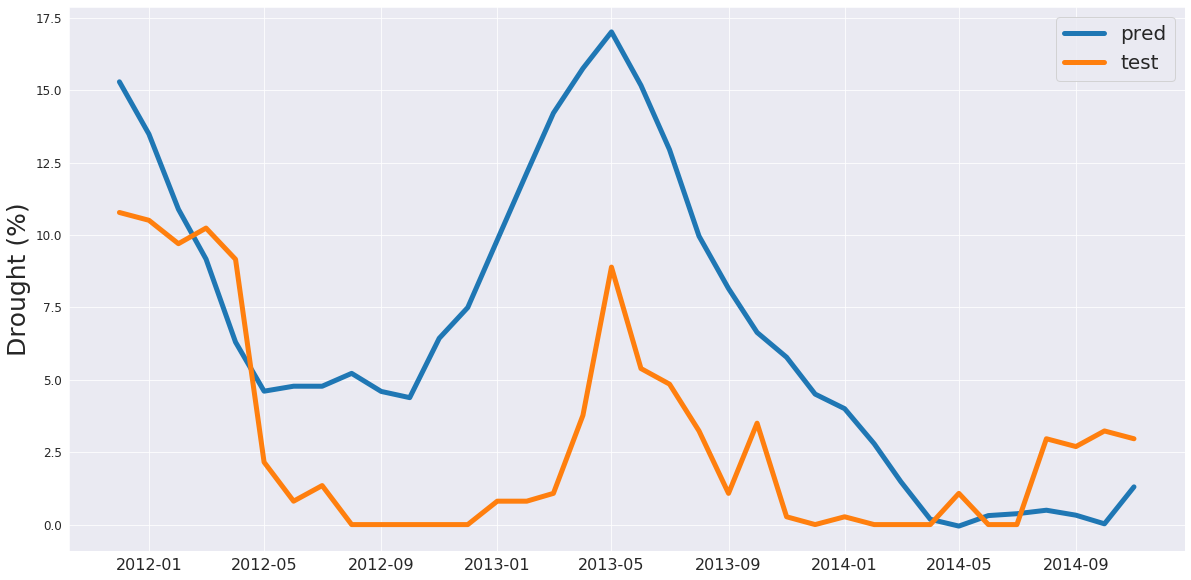

In [139]:
limit = -1
y_pred = model.predict(x_test)
#x = range(len(y_pred))
plt.plot(x[:limit],100*y_pred[:limit]/N,label = 'pred', linewidth = 5)
plt.plot(x[:limit],100*y_test[:limit]/N, label = 'test', linewidth = 5)
plt.ylabel("Drought (%)", fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=20)
plt.savefig("ET_pred_test_ijz_2_extreme_1.png")

In [120]:
y_pred.s

(37, 1)

In [124]:
sns.set_style(style="darkgrid")

In [121]:
data  = pd.DataFrame({"date":x, "test":np.ravel(y_test), "pred":np.ravel(y_pred)})

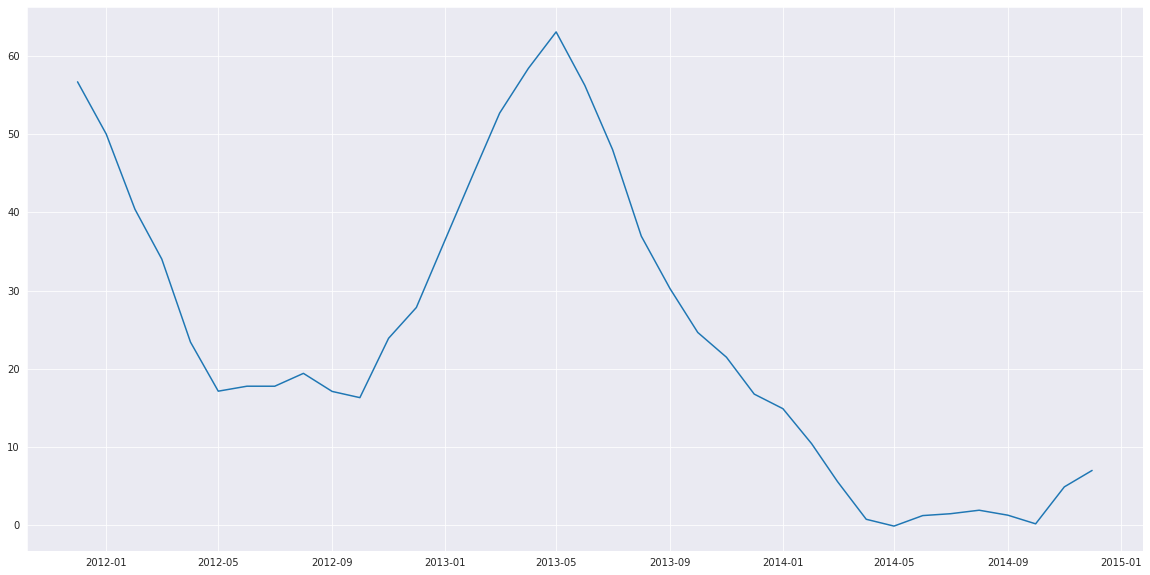

In [125]:
sns.lineplot(x,np.ravel(y_pred))

In [ ]:
x,o

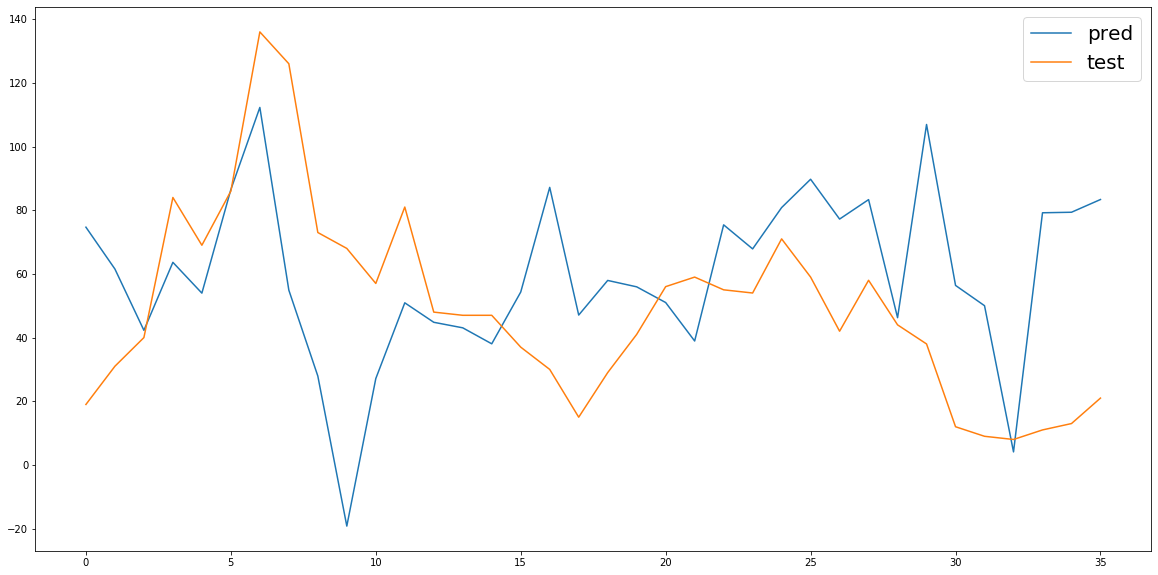

In [17]:
limit = -1
y_pred = model.predict(x_test)
x = range(len(y_pred))
plt.plot(x[:limit],y_pred[:limit],label = 'pred')
plt.plot(x[:limit],y_test[:limit], label = 'test')
plt.legend(fontsize=20)

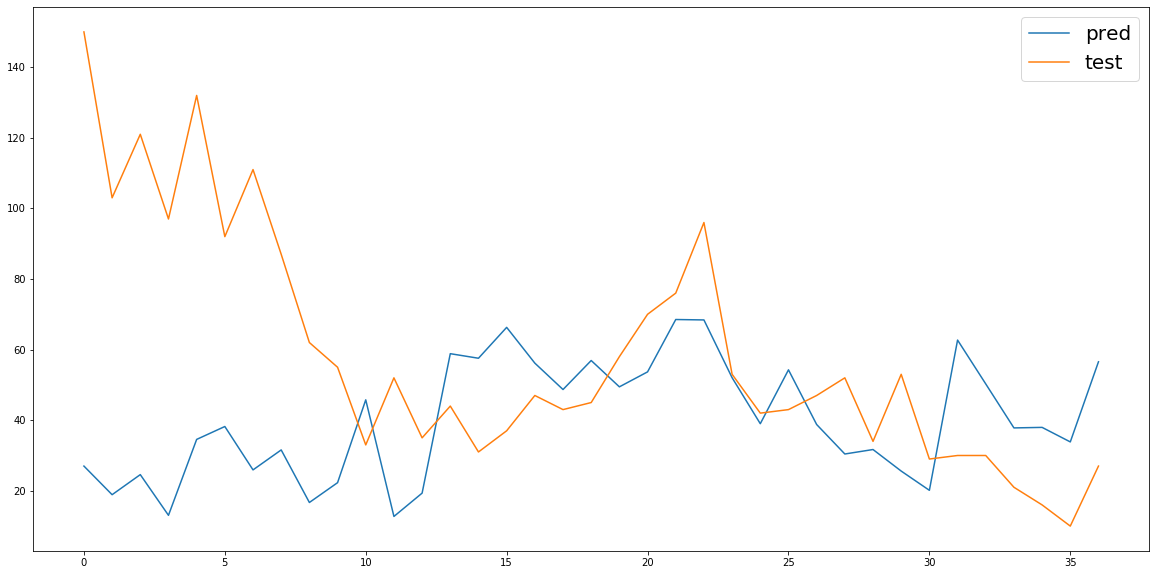

In [53]:
y_pred = model.predict(x_test)
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

In [128]:
mean_squared_error(y_pred,y_test)

949.3764036956628

In [143]:
y_pred = model.predict(x_test)

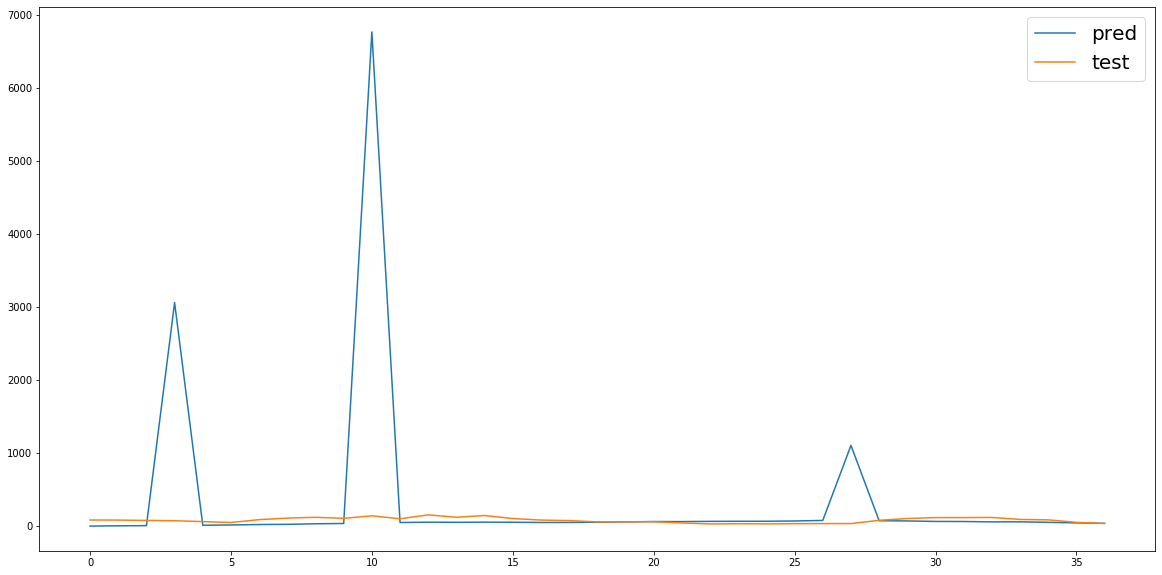

In [144]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

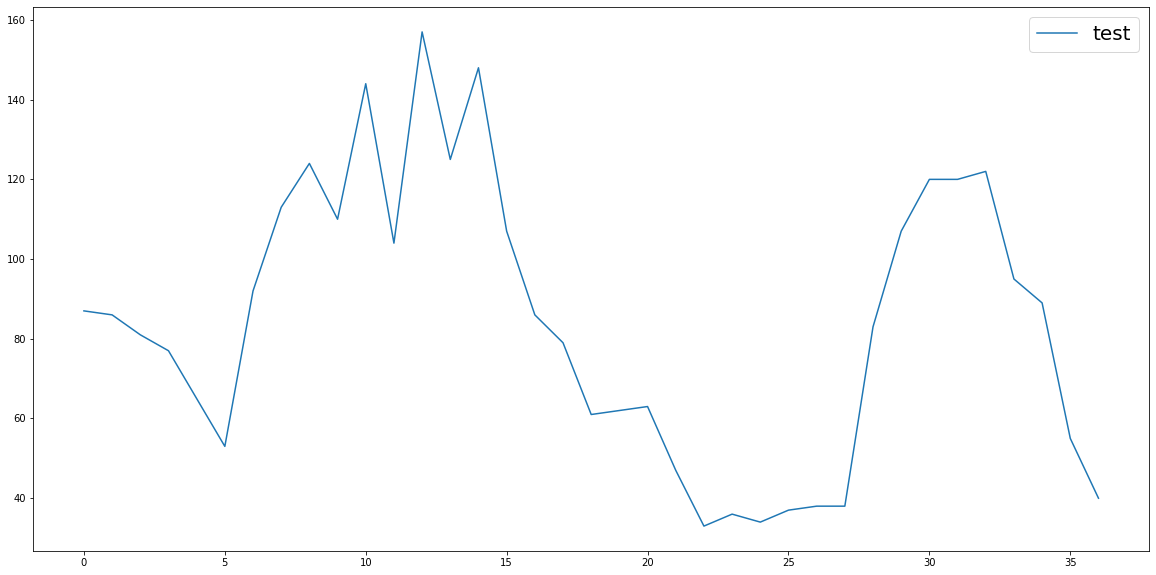

In [146]:
x = range(len(y_pred))
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

In [15]:
%tensorboard --logdir logs/scalars